In [1]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/disorder/PBC/


In [ ]:
from statistics import mean


dir = "../results/XYZ/disorder/OBC/Entropy/Eigenstate/"
L=10
J=0.5
J0=0.5
g=0.9
g0=0.9
h=0.8
w=0.2

fig, ax = plt.subplots( nrows=1, ncols=4, figsize=(16,5), dpi = 500)

validL = []
Smean = []
gap_ratio = []
def plot_here(axis, L):
    info = hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    Smax = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
    Spage = L * np.log(2) / 2. - 0.5
    filename = info + "_subsize=%d.hdf5"%(L/2)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % f.keys())
            energies = np.array(f.get('energies')[0])
            entropy = np.array(f.get('entropy')[0])
            eigenvectors = np.array(f.get('eigenvectors'))
        
        axis.scatter(energies, entropy, label=r"$L=%d$"%L, s=4)
        axis.axhline(y=Smax, linestyle='--', color='black', label="Vidmar2019")
        axis.axhline(y=Spage, linestyle='--', color='red', label="Page")
        axis.set_ylim(0, 5.5)
        axis.set_xlim(-10, 15)
        axis.legend()
        # ENTROPY USING NUMPY
        #entropy_python = []
        #nA = int(2**(L/2))
        #for state in eigenvectors:
        #    rho = np.outer(state, state).reshape([nA, nA, nA, nA])
        #    rho_a = np.trace(rho, axis1=1, axis2=3)
        #    rho_b = np.trace(rho, axis1=0, axis2=2)
        #    U, s, V = np.linalg.svd(rho_a)
        #    entropy_python.append(-np.sum(s * np.log(s)))
        #    #entropy_python.append(-np.trace(rho_a * np.log(rho_a)))
        #entropy_python = np.array(entropy_python)
        #axis.scatter(energies, entropy_python, marker='s', facecolor='None', edgecolor='red', label=r"$L=%d$"%L,s=10)
        #diff = np.abs(entropy - entropy_python)
        #diff = [x for x in diff if x > 1e-14]
        #print(diff)
        
        # get mean
        size = energies.size
        my_min = int(0.5 * size - 100)
        my_max = int(0.5 * size + 100)
        print(size, my_min, my_max)
        
        sample = entropy[my_min : my_max]
        
        meanS = np.mean(sample)
        validL.append(L)
        Smean.append(meanS)
        gaps = np.diff(energies)
        
        ratio = 0
        counter = 0
        for i in range(int(0.25 * size), int(0.75 * size)):
            ratio += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1
        gap_ratio.append(ratio / counter)


plot_here(axis=ax[0], L=8)
plot_here(axis=ax[0], L=10)
plot_here(axis=ax[1], L=12)
plot_here(axis=ax[2], L=14)
plot_here(axis=ax[3], L=16)

def page(L):    
    return L * np.log(2) / 2. - 0.5
def Srand(L): 
    return L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
#Ls = np.array(range(7,17))
validL = np.array(validL)
#ax[3].scatter(validL, np.abs(np.array(Smean) - page(validL)), label=r"$\langle S\rangle_{200\ states}-S_{page}$")
#ax[3].plot(Ls, np.abs(Srand(Ls) - page(Ls)), linestyle='--', label=r"$S_{rand}-S_{page}$")
#ax[3].legend()
#ax[3].set_xlim(6, 18)
#ax[3].set_xscale('log')
#ax[3].set_yscale('log')

plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig1.pdf")
plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig1.png")

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
ax_1 = ax.twinx()
ax.scatter(validL, Smean, label=r"$\langle S\rangle_{200 states}$")
ax.plot(validL, Srand(validL), linestyle='--', label=r"$S_{rand}$")
ax.plot(validL, page(validL), linestyle='--', label=r"$S_{page}$")
ax_1.scatter(validL, gap_ratio, color='red')
ax_1.set_ylim(0.38, 0.55)
ax_1.set_ylabel(r"$\langle r\rangle_E$", color='red', fontsize=12)
ax_1.tick_params(axis='y', color='red', labelcolor='red')

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)

Smean_ener = []
S_dos = []
S_max_ent = []
validL = []

for L in range(8, 17, 2):    
    info = hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    filename = info + "_subsize=%d.hdf5"%(L/2)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % f.keys())
            energies = np.array(f.get('energies')[0])
            entropy = np.array(f.get('entropy')[0])
        
        
        size = energies.size

        # get mean energy
        def get_S(idx):
            num = 500 if L > 8 else 100
            #num = 0.5 * size
            my_min = int(idx - num / 2);    
            if my_min < 0: my_min = 0
            my_max = int(idx + num / 2);    
            if my_max>= size: my_max = size

            print(size, my_min, my_max, idx)
            sample = entropy[my_min : my_max]
            return np.mean(sample)

        E_av = np.sum(energies) / size
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        Smean_ener.append(get_S(idx))

        E_av = np.median(energies)
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        S_dos.append(get_S(idx))
        
        E_av = max(entropy)
        idx = min(range(len(entropy)), key=lambda i: abs(entropy[i] - E_av))
        S_max_ent.append(get_S(idx))
        
        validL.append(L)

def Srand(L): 
    return L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5

def page(L):    
    return L * np.log(2) / 2. - 0.5
validL = np.array(validL)
def plot_with_fit(axis, sizes, entropy, label = "oh"):
    ydata = np.abs(entropy - page(sizes))

    pars, sth = fit(f=lin_fit_inv, 
                        xdata=sizes[2:], 
                        ydata=ydata[2:])
    
    p = axis.plot(1. / sizes, ydata, marker='o', label=label)
    Ls = np.linspace(0, 0.2, 100)
    axis.plot(Ls, lin_fit_inv(1./Ls, *pars), linestyle='--', color=p[0].get_color())

plot_with_fit(axis=ax, sizes=validL, entropy=S_dos, label="max dos")
plot_with_fit(axis=ax, sizes=validL, entropy=Smean_ener, label=r"$E_{av}$")
plot_with_fit(axis=ax, sizes=validL, entropy=S_max_ent, label="max entropy")

ax.axhline(y=0.0966, linestyle=':', color='black', label="limit")
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,0.15)
ax.set_ylim(0,None)
ax.legend()

_L=*,J=1.00,J0=0.00,g=*,g0=0.00,h=0.00,w=0.70_subsize=*_jobid=*.hdf5
_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.70
_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.70
_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.70
_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.70
[10 12]
[0.55]
[0]


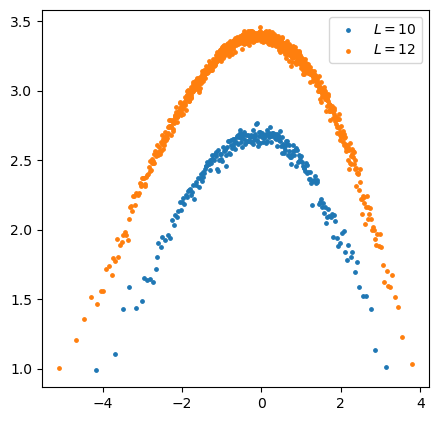

In [71]:
from fnmatch import fnmatch as fn
dir_in = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}raw_data{os.sep}"
dir_out = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}"


ii = user_settings['scaling_idx']
info = ""
# ASSUMING DISORDER MODULE FOR NOW
arr = [cf.J, cf.J0, cf.g, cf.g0, cf.h, cf.w]
names = ['J', 'J0', 'g', 'g0', 'h', 'w']
indices = [-1, 0, 2, 4, 5]
def create_info(use_log_data = True):
    info = "_L=*"
    for i, var in enumerate(arr):
        n = hfun.order_of_magnitude(var) if use_log_data else 2
        if i == indices[ii]:
            info += ",%s=*"%names[i]
        else: info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info + "_subsize=*_jobid=*.hdf5"
info = create_info()
print(info)

sizes = []
collected_pars = []
realis = []
#--------------------------------------- COLLECT DATA
def append_parameter_range(filename):
    if fn(filename, info):
        bare_info, extension = os.path.splitext(filename)
        print(base_info)
        f = os.path.join(dir_in, filename)
        if os.path.isfile(f):
            pars = hfun.get_params_from_info(bare_info)
            
            if pars[ii] not in collected_pars:  collected_pars.append(pars[ii])
            if pars[0] not in sizes:            sizes.append(int(pars[0]))
            if pars[-1] not in realis:          realis.append(int(pars[-1]))

for filename in os.listdir(dir_in): 
    info = create_info()
    append_parameter_range(filename)
    info = create_info(False)
    append_parameter_range(filename)

pars = cf.params_arr
sizes = np.sort(sizes)
collected_pars = np.sort(collected_pars)
realis = np.sort(realis)
print(sizes)
print(collected_pars)
print(realis)

sizes = sizes if ii != 0 else [0];
entropy = []
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
for L in sizes:
    new_pars = pars
    if ii != 0:
        new_pars[0] = L

    info_out = dir_out + hfun.remove_info(hfun.info_param(new_pars), user_settings['scaling']) + "_subsize=%d.hdf5"%(L/2)
    S = []
    i = 0
    for par in collected_pars:
        new_pars[ii] = par
        info_in = hfun.info_param(new_pars)
        base_info, ext = os.path.splitext(info_in)
        
        info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%r
        ener = []
        ent = []
        counter = 1.0
        if os.path.exists(dir_in + info_in):
            with h5py.File(dir_in + info_in, "r") as f:
                # Print all root level object names (aka keys) 
                # these can be group or dataset names 
                ener = np.array(f.get('energies')[0])
                ent = np.array(f.get('entropy')[0])
        for r in realis[1:]:
            info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%r
            
            if os.path.exists(dir_in + info_in):
                with h5py.File(dir_in + info_in, "r") as f:
                    # Print all root level object names (aka keys) 
                    # these can be group or dataset names 
                    ener += np.array(f.get('energies')[0])
                    ent += np.array(f.get('entropy')[0])
                    counter += 1.0
                    
        ener = np.array(ener) / counter
        ent = np.array(ent) / counter       
        
        ax.scatter(ener, ent, label=r"$L=%d$"%L,s=6)    

        S.append(np.mean(ent))
    entropy.append(np.array(S))    
ax.legend()